# Chatbot

Options :

In [1]:
train_model = True
#train_model = False

In [2]:
api = False
#api = True

In [3]:
#test = False
test = True

Importer les modules nécessaires :

In [4]:
import json
import pandas as pd
from nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from nltk.corpus import stopwords 
from langdetect import detect_langs
import unicodedata

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session

from sklearn.preprocessing import LabelEncoder


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import random
import numpy as np

from keras.models import load_model

from flask import Flask, render_template, request

import pickle

Obtenir la DataFrame à partir de ``content.json`` :

In [5]:
#ouvrir le fichier JSON
from connecteur import Connecteur

In [6]:
data1 = Connecteur.get_all_data()

In [7]:


#créer les listes vides
tags = []
inputs = []
responses={}
#les remplir avec le contenu du JSON
for intent in data1['intents']:
  responses[intent['tag']]=intent['liste_output']
  for lines in intent['liste_input']:
    inputs.append(lines)
    tags.append(intent['tag'])
    
#convertir en DataFrame
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

#mélanger aléatoirement
data = data.sample(frac=1)

#montrer la DataFrame
display(data)
#montrer les catégories
data["tags"].value_counts()

,inputs,tags
422,Y a-t-il des examens pendant la formation ?,evaluation
430,Examens,evaluation
998,What do I have to do to complete the program?,en_evaluation
931,What teachers will the students have?,en_enseignants
686,"Hi, how are you ?",en_salutation
...,...,...
603,I am looking for training,en_apprenant
333,Diplôme ?,titre
1014,What jobs are we being trained for?,en_debouches
203,Quel niveau d'étude est demandé ?,admission


apprenant             53
debouches             47
admission             42
en_covid              41
partenaire            38
en_aide financiere    37
covid                 36
en_apprenant          36
en_negation           35
alternance            33
en_salutation         32
en_partner            32
en_titre              32
pédagogie             31
en_affirmation        31
en_admission          31
evaluation            31
code                  31
enseignants           30
en_evaluation         30
en_alternance         29
en_pédagogie          28
titre                 27
salutation            27
en_debouches          27
fin                   26
en_fin                25
affirmation           24
date                  23
en_code               23
en_date               22
en_enseignants        20
negation              20
en_insultes           16
aide financiere        6
insultes               5
Name: tags, dtype: int64

Créer les fonctions de traitement du texte :

In [8]:
#enlever les accents du texte
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return str(only_ascii)[2:-1]

In [9]:
#définir les stopwords
stop_words_en = list(set(stopwords.words('english')))
stop_words_fr = list(set(stopwords.words('french')))

#rajouter aux stopwords français leurs versions sans accents
stop_words_fr_1 = []
for word in stop_words_fr:
    word = remove_accents(word)
    stop_words_fr_1.append(word)
stop_words_fr = list(sorted(set(stop_words_fr + stop_words_fr_1)))

In [10]:
#traiter le texte
def treatment(text):
    #vérifier si c'est une question
    if text[-1] == "?":
        question = "?"
    else:
        question = "0"
        
    #vérifier la langue
    language_list = detect_langs(text)
    language_list_2 = []
    for language in language_list:
        language = str(language).split(":")[0]
        language_list_2.append(language)
    if "fr" in language_list_2:
        language = "francais"
    elif "en" in language_list_2:
        language = "anglais"
    else:
        language = "francais"
    
    #segmenter le texte et traiter chaque mot et chaque lettre
    text = text.split()
    words_list = []
    for word in text:
        letters_list = []
        for character in word:
            #vérifier que le caractère est une lettre
            if character.isalpha():
                #rajouter à la liste en minuscule
                letters_list.append(character.lower())
            else:
                letters_list.append(" ")
        word = "".join(letters_list)
        
        #appliquer le stemming suivant la langue
        for word1 in word.split():
            word_yes = False
            if language == "anglais":
                if word1 not in stop_words_en:
                    word1 = EnglishStemmer().stem(word1)
                    word_yes = True
            else:
                if word1 not in stop_words_fr:
                    word1 = FrenchStemmer().stem(word1)
                    word_yes = True
            #enlever les accents
            if word_yes == True:
                word1 = remove_accents(word1)
                words_list.append(word1)
            
    #joindre en une string
    text = " ".join(words_list)
    return " ".join([text, question, language])
    #pour avoir en trois colonnes
    #return [text, question, language]

Obtenir une colonne avec les inputs traités :

In [11]:
#pour avoir en trois colonnes

#text_list = []
#ques_list = []
#lang_list = []

#for value in data["inputs"]:
    #value = treatment(value)
    #text_list.append(value[0])
    #ques_list.append(value[1])
    #lang_list.append(value[2])

#data["text"] = text_list
#data["?"] = ques_list
#data["language"] = lang_list

In [12]:
data["texts"] = data["inputs"].apply(treatment)

In [13]:
data

,inputs,tags,texts
422,Y a-t-il des examens pendant la formation ?,evaluation,examen pend format ? francais
430,Examens,evaluation,examen 0 francais
998,What do I have to do to complete the program?,en_evaluation,complet program ? anglais
931,What teachers will the students have?,en_enseignants,teacher student ? anglais
686,"Hi, how are you ?",en_salutation,hi ? anglais
...,...,...,...
603,I am looking for training,en_apprenant,look train 0 anglais
333,Diplôme ?,titre,diplom ? francais
1014,What jobs are we being trained for?,en_debouches,job train ? anglais
203,Quel niveau d'étude est demandé ?,admission,quel niveau etud demand ? francais


Appliquer le tokenizer sur les inputs traités :

In [14]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['texts'])
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

train = tokenizer.texts_to_sequences(data['texts'])
#apply padding
x_train = pad_sequences(train)

In [15]:
x_train

array([[  0,   0,   0, ..., 176,   4,   1],
       [  0,   0,   0, ..., 142,   3,   1],
       [  0,   0,   0, ...,  29,   7,   2],
       ...,
       [  0,   0,   0, ...,  46,  40,   2],
       [  0,   0,   0, ..., 126, 503,   1],
       [  0,   0,   0, ...,  67,  31,   1]])

Appliquer LabelEncoder() sur les tags :

In [16]:
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [17]:
input_shape = x_train.shape[1]
print(input_shape)

10


In [18]:
vocabulary = len(tokenizer.word_index)
print("Nombre de mots uniques : ",vocabulary)
output_length = le.classes_.shape[0]
print("Taille des outputs : ",output_length)

Nombre de mots uniques :  503
Taille des outputs :  36


### Validation

Séparer ``x_train`` et ``y_train`` en ``train`` et ``val`` pour la validation :

In [19]:
#longueur d'1/5 du Dataset
prod=int(len(x_train)* 0.2)

#séparation en x_val et x_train
x_val=x_train[-prod:, :]
x_train=x_train[:-prod, :]

In [20]:
#séparation en y_val et y_train
y_val=y_train[ -prod:]
y_train=y_train[:-prod]

In [21]:
display(x_val.shape,x_train1.shape,y_val.shape,y_train1.shape)

(211, 10)

(846, 10)

(211,)

(846,)

Créer et entraîner le modèle :

In [27]:
if train_model == True:
    #créer le modèle
    i = Input(shape=(input_shape,))
    x = Embedding(vocabulary+1,10)(i)
    #x = LSTM(10,return_sequences=True)(x)
    x = Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10))(x)
    x = Bidirectional(LSTM(10))(x)
    x = Flatten()(x)
    x = Dense(output_length,activation="softmax")(x)
    model  = Model(i,x)

    #compiler le modèle
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

    #enregistrer le modèle à son meilleur résultat
    model_name = "model_py/model.h5"

    modelcheckpoint = ModelCheckpoint(model_name,
                                      monitor='val_loss',
                                      mode='auto',
                                      verbose=1,
                                      save_best_only=True)

    callback_list = [modelcheckpoint]
    
    #entraîner le modèle
    history = model.fit(x_train,y_train,epochs=300, validation_data=(x_val, y_val), callbacks=callback_list)
    clear_session()

Epoch 1/300
34/34 [==============================] - ETA: 0s - loss: 3.5802 - accuracy: 0.0482
Epoch 00001: loss improved from inf to 3.58019, saving model to model_py\model.h5
34/34 [==============================] - 1s 17ms/step - loss: 3.5802 - accuracy: 0.0482
Epoch 2/300
34/34 [==============================] - ETA: 0s - loss: 3.5678 - accuracy: 0.0501
Epoch 00002: loss improved from 3.58019 to 3.56776, saving model to model_py\model.h5
34/34 [==============================] - 1s 17ms/step - loss: 3.5678 - accuracy: 0.0501
Epoch 3/300
34/34 [==============================] - ETA: 0s - loss: 3.5422 - accuracy: 0.0501
Epoch 00003: loss improved from 3.56776 to 3.54223, saving model to model_py\model.h5
34/34 [==============================] - 1s 17ms/step - loss: 3.5422 - accuracy: 0.0501
Epoch 4/300
34/34 [==============================] - ETA: 0s - loss: 3.4795 - accuracy: 0.0530
Epoch 00004: loss improved from 3.54223 to 3.47946, saving model to model_py\model.h5
34/34 [=========

Epoch 32/300
31/34 [==========================>...] - ETA: 0s - loss: 0.7527 - accuracy: 0.8770
Epoch 00032: loss improved from 0.77246 to 0.74481, saving model to model_py\model.h5
34/34 [==============================] - 0s 13ms/step - loss: 0.7448 - accuracy: 0.8808
Epoch 33/300
31/34 [==========================>...] - ETA: 0s - loss: 0.7230 - accuracy: 0.8881
Epoch 00033: loss improved from 0.74481 to 0.72867, saving model to model_py\model.h5
34/34 [==============================] - 0s 12ms/step - loss: 0.7287 - accuracy: 0.8827
Epoch 34/300
30/34 [=========================>....] - ETA: 0s - loss: 0.7450 - accuracy: 0.8667
Epoch 00034: loss did not improve from 0.72867
34/34 [==============================] - 0s 11ms/step - loss: 0.7459 - accuracy: 0.8638
Epoch 35/300
31/34 [==========================>...] - ETA: 0s - loss: 0.6683 - accuracy: 0.8942
Epoch 00035: loss improved from 0.72867 to 0.67662, saving model to model_py\model.h5
34/34 [==============================] - 0s 13m

30/34 [=========================>....] - ETA: 0s - loss: 0.3009 - accuracy: 0.9510
Epoch 00063: loss improved from 0.30109 to 0.30005, saving model to model_py\model.h5
34/34 [==============================] - 1s 15ms/step - loss: 0.3001 - accuracy: 0.9527
Epoch 64/300
32/34 [===========================>..] - ETA: 0s - loss: 0.2907 - accuracy: 0.9541
Epoch 00064: loss improved from 0.30005 to 0.28599, saving model to model_py\model.h5
34/34 [==============================] - 0s 14ms/step - loss: 0.2860 - accuracy: 0.9555
Epoch 65/300
31/34 [==========================>...] - ETA: 0s - loss: 0.2781 - accuracy: 0.9607
Epoch 00065: loss improved from 0.28599 to 0.27760, saving model to model_py\model.h5
34/34 [==============================] - 0s 13ms/step - loss: 0.2776 - accuracy: 0.9593
Epoch 66/300
31/34 [==========================>...] - ETA: 0s - loss: 0.2708 - accuracy: 0.9597
Epoch 00066: loss improved from 0.27760 to 0.27163, saving model to model_py\model.h5
34/34 [==============

31/34 [==========================>...] - ETA: 0s - loss: 0.1756 - accuracy: 0.9698
Epoch 00095: loss did not improve from 0.17624
34/34 [==============================] - 0s 10ms/step - loss: 0.1791 - accuracy: 0.9659
Epoch 96/300
34/34 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9697
Epoch 00096: loss improved from 0.17624 to 0.17294, saving model to model_py\model.h5
34/34 [==============================] - 0s 13ms/step - loss: 0.1729 - accuracy: 0.9697
Epoch 97/300
30/34 [=========================>....] - ETA: 0s - loss: 0.1685 - accuracy: 0.9667
Epoch 00097: loss improved from 0.17294 to 0.17089, saving model to model_py\model.h5
34/34 [==============================] - 0s 13ms/step - loss: 0.1709 - accuracy: 0.9659
Epoch 98/300
30/34 [=========================>....] - ETA: 0s - loss: 0.1676 - accuracy: 0.9677
Epoch 00098: loss improved from 0.17089 to 0.16879, saving model to model_py\model.h5
34/34 [==============================] - 0s 13ms/step - loss

30/34 [=========================>....] - ETA: 0s - loss: 0.1144 - accuracy: 0.9740
Epoch 00127: loss improved from 0.11892 to 0.11661, saving model to model_py\model.h5
34/34 [==============================] - 0s 13ms/step - loss: 0.1166 - accuracy: 0.9726
Epoch 128/300
31/34 [==========================>...] - ETA: 0s - loss: 0.1161 - accuracy: 0.9738
Epoch 00128: loss improved from 0.11661 to 0.11329, saving model to model_py\model.h5
34/34 [==============================] - 0s 12ms/step - loss: 0.1133 - accuracy: 0.9745
Epoch 129/300
31/34 [==========================>...] - ETA: 0s - loss: 0.1121 - accuracy: 0.9718
Epoch 00129: loss improved from 0.11329 to 0.11014, saving model to model_py\model.h5
34/34 [==============================] - 0s 12ms/step - loss: 0.1101 - accuracy: 0.9726
Epoch 130/300
34/34 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9745
Epoch 00130: loss improved from 0.11014 to 0.10905, saving model to model_py\model.h5
34/34 [===========

31/34 [==========================>...] - ETA: 0s - loss: 0.0780 - accuracy: 0.9829
Epoch 00160: loss improved from 0.07995 to 0.07950, saving model to model_py\model.h5
34/34 [==============================] - 0s 14ms/step - loss: 0.0795 - accuracy: 0.9811
Epoch 161/300
31/34 [==========================>...] - ETA: 0s - loss: 0.0804 - accuracy: 0.9808
Epoch 00161: loss improved from 0.07950 to 0.07826, saving model to model_py\model.h5
34/34 [==============================] - 0s 12ms/step - loss: 0.0783 - accuracy: 0.9820
Epoch 162/300
30/34 [=========================>....] - ETA: 0s - loss: 0.0799 - accuracy: 0.9802
Epoch 00162: loss did not improve from 0.07826
34/34 [==============================] - 0s 11ms/step - loss: 0.0785 - accuracy: 0.9801
Epoch 163/300
31/34 [==========================>...] - ETA: 0s - loss: 0.0760 - accuracy: 0.9819
Epoch 00163: loss improved from 0.07826 to 0.07571, saving model to model_py\model.h5
34/34 [==============================] - 0s 13ms/step - l

34/34 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9678
Epoch 00193: loss did not improve from 0.06348
34/34 [==============================] - 0s 11ms/step - loss: 0.1205 - accuracy: 0.9678
Epoch 194/300
30/34 [=========================>....] - ETA: 0s - loss: 0.0803 - accuracy: 0.9802
Epoch 00194: loss did not improve from 0.06348
34/34 [==============================] - 0s 11ms/step - loss: 0.0826 - accuracy: 0.9782
Epoch 195/300
31/34 [==========================>...] - ETA: 0s - loss: 0.0677 - accuracy: 0.9839
Epoch 00195: loss did not improve from 0.06348
34/34 [==============================] - 0s 11ms/step - loss: 0.0681 - accuracy: 0.9839
Epoch 196/300
33/34 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9830
Epoch 00196: loss did not improve from 0.06348
34/34 [==============================] - 0s 12ms/step - loss: 0.0700 - accuracy: 0.9830
Epoch 197/300
30/34 [=========================>....] - ETA: 0s - loss: 0.0755 - accura

Epoch 226/300
34/34 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9849
Epoch 00226: loss improved from 0.04939 to 0.04862, saving model to model_py\model.h5
34/34 [==============================] - 0s 13ms/step - loss: 0.0486 - accuracy: 0.9849
Epoch 227/300
31/34 [==========================>...] - ETA: 0s - loss: 0.0483 - accuracy: 0.9879
Epoch 00227: loss did not improve from 0.04862
34/34 [==============================] - 0s 10ms/step - loss: 0.0498 - accuracy: 0.9858
Epoch 228/300
33/34 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.9735
Epoch 00228: loss did not improve from 0.04862
34/34 [==============================] - 0s 12ms/step - loss: 0.0801 - accuracy: 0.9735
Epoch 229/300
33/34 [============================>.] - ETA: 0s - loss: 0.0970 - accuracy: 0.9716
Epoch 00229: loss did not improve from 0.04862
34/34 [==============================] - 1s 16ms/step - loss: 0.0969 - accuracy: 0.9716
Epoch 230/300
34/34 [============

Epoch 260/300
33/34 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9867
Epoch 00260: loss improved from 0.04279 to 0.04251, saving model to model_py\model.h5
34/34 [==============================] - 0s 14ms/step - loss: 0.0425 - accuracy: 0.9868
Epoch 261/300
34/34 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9839
Epoch 00261: loss did not improve from 0.04251
34/34 [==============================] - 0s 11ms/step - loss: 0.0433 - accuracy: 0.9839
Epoch 262/300
31/34 [==========================>...] - ETA: 0s - loss: 0.0527 - accuracy: 0.9808
Epoch 00262: loss did not improve from 0.04251
34/34 [==============================] - 0s 11ms/step - loss: 0.0547 - accuracy: 0.9811
Epoch 263/300
31/34 [==========================>...] - ETA: 0s - loss: 0.0523 - accuracy: 0.9829
Epoch 00263: loss did not improve from 0.04251
34/34 [==============================] - 0s 11ms/step - loss: 0.0519 - accuracy: 0.9830
Epoch 264/300
33/34 [============

Epoch 294/300
34/34 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9849
Epoch 00294: loss did not improve from 0.03856
34/34 [==============================] - 0s 12ms/step - loss: 0.0428 - accuracy: 0.9849
Epoch 295/300
32/34 [===========================>..] - ETA: 0s - loss: 0.0387 - accuracy: 0.9844
Epoch 00295: loss did not improve from 0.03856
34/34 [==============================] - 0s 10ms/step - loss: 0.0401 - accuracy: 0.9839
Epoch 296/300
32/34 [===========================>..] - ETA: 0s - loss: 0.0384 - accuracy: 0.9854
Epoch 00296: loss did not improve from 0.03856
34/34 [==============================] - 0s 11ms/step - loss: 0.0386 - accuracy: 0.9849
Epoch 297/300
31/34 [==========================>...] - ETA: 0s - loss: 0.0386 - accuracy: 0.9849
Epoch 00297: loss improved from 0.03856 to 0.03829, saving model to model_py\model.h5
34/34 [==============================] - 0s 12ms/step - loss: 0.0383 - accuracy: 0.9849
Epoch 298/300
32/34 [============

Faire une prédiction sur ``x_val`` :

In [23]:
#obtenir les arguments pour chaque ligne
y_pred=model.predict(x_val)

In [24]:
#récupérer l'argument maximal sur chaque ligne
y_pred_2 =[]
for pred in y_pred:
    y_pred_2.append(pred.argmax())
y_pred_2 = np.array(y_pred_2)
y_pred_2

array([ 1,  7,  4, 19,  9, 32,  3, 34, 23, 31, 12, 14, 27, 22,  0,  7, 28,
       26, 20,  5, 22, 33, 33, 15,  5, 16, 20, 28,  8, 19,  1, 32,  0, 26,
       22,  8, 15, 28, 11,  7, 34, 19, 16, 28, 19,  3, 34, 24, 26, 18, 16,
       15,  6, 29, 33, 25, 34,  1,  9, 23, 22, 25,  1, 25, 17, 10, 15,  2,
       28,  9,  0, 15,  4, 18,  6, 24, 33, 29, 24, 27,  8, 25, 26,  3, 35,
       13, 26,  0, 19, 28, 23, 19, 31,  0,  8, 17,  2, 15,  7, 32,  1,  4,
       14, 11,  2, 29, 28, 32,  7, 18, 32, 13, 16, 16, 16, 16,  8, 32,  7,
       20,  5,  8, 11,  9, 11, 10,  1, 11, 26,  8, 19, 22, 12, 12, 23, 28,
       23, 16,  8, 34,  8,  6,  2, 22,  4,  7, 23, 31, 22,  4,  0, 25, 34,
       10,  5, 27, 22, 13, 15, 22, 29, 26, 17,  1, 35, 15, 12, 12,  6, 26,
       22,  1,  6,  3,  8,  0, 29,  0,  8,  0,  0, 24, 22, 16, 10, 13, 12,
        0, 19, 28,  1, 13,  0,  3, 34,  1, 13, 11, 11, 35, 22, 27,  1,  5,
        1, 22, 15, 26, 17, 20,  8], dtype=int64)

faire une matrice de confusion pour comparer y_train de y_val

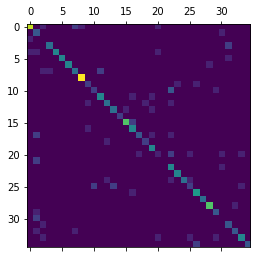

In [25]:
cm = confusion_matrix( y_val , y_pred_2)
plt.matshow(cm)

### Historique

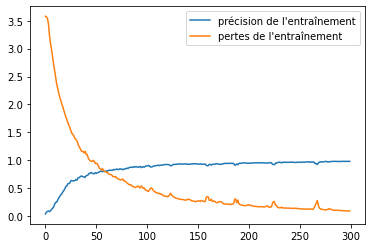

In [26]:
if train_model == True:
    #montrer l'historique de précision et des pertes
    plt.plot(history.history['accuracy'],label="précision de l'entraînement")
    plt.plot(history.history['loss'],label="pertes de l'entraînement")
    plt.legend()

In [28]:
if train_model == False:
    model = load_model("model_py/model.h5")

## Test

Taper 0 pour sortir.

In [29]:
if test == True:
    while True:
      texts_p = []
      prediction_input = input('Vous : ')
      if prediction_input == "0":
        break

      #appliquer la fonction treatment
      prediction_input = treatment(prediction_input)
      texts_p.append(prediction_input)
      print(prediction_input)

      #tokenizer et padding
      prediction_input = tokenizer.texts_to_sequences(texts_p)
      prediction_input = np.array(prediction_input).reshape(-1)
      prediction_input = pad_sequences([prediction_input],input_shape)
      print(prediction_input)

      #obtenir la prédiction du modèle
      output = model.predict(prediction_input)
      output = output.argmax()
      print(output)

      #trouver la tag correspondante et la réponse
      response_tag = le.inverse_transform([output])[0]
      print(response_tag)
      #print("Chatbot : ",random.choice(responses[response_tag]))
      if response_tag == "goodbye":
        break

Vous : Bonjour.
bonjour 0 francais
[[ 0  0  0  0  0  0  0 48  3  1]]
34
salutation
Vous : Je suis partenaire.
partenair 0 francais
[[ 0  0  0  0  0  0  0 16  3  1]]
32
partenaire
Vous : Quand commence la formation ?
quand commenc format ? francais
[[  0   0   0   0   0   0  61 156   4   1]]
7
date
Vous : 0


## API

In [30]:
if api == True:
    app = Flask(__name__)

    s_list = ["inconnu", "apprenant", "partenaire"]
    user_status = s_list[0]

    #créer deux listes de tags identifiant l'utilisateur comme étant apprenant ou partenaire
    appr_list = []
    part_list = []

    #créer deux dictionnaires avec les équivalents d'output apprenant/partenaire
    to_appr = {}
    to_part = {}


    #definir les app.route
    @app.route("/")
    def index():
        return render_template("index.html")

    @app.route("/get")
    #fonction de réponse
    def get_bot_response():
        #obtenir la question et la formatter
        texts_p = []
        prediction_input = request.args.get('msg')
        prediction_input = treatment(prediction_input)
        texts_p.append(prediction_input)

        #formatter l'input
        prediction_input = tokenizer.texts_to_sequences(texts_p)
        prediction_input = np.array(prediction_input).reshape(-1)
        prediction_input = pad_sequences([prediction_input],input_shape)

        #prédire l'output
        output = model.predict(prediction_input)
        output = output.argmax()

        #vérifier si l'output identifie l'utilisateur
        if output in appr_list:
            user_status = s_list[1]
        elif output in part_list:
            user_status = s_list[2]

        #si l'utilisateur est identifié et l'output est susceptible de changer pour ça, alors le changer
        if user_status == s_list[1] and output in to_appr.keys():
            output = to_appr[output]
        elif user_status == s_list[2] and output in to_part.keys():
            output = to_part[output]

        #transformer la réponse et la renvoyer
        response_tag = le.inverse_transform([output])[0]
        response = str("Chatbot : ",random.choice(responses[response_tag]))
        return response

    #lancer l'API
    if __name__ == "__main__":
        app.run()